План работы: 

1. Изучить таблицы и "склеить" их по id. Если размеры датафреймов разные, то то что можно - склеить, остальные просто добавить отдельной строкой.

2. Изучить столбцы на информативность, так как не все столбцы имеют значимость. Провести предобоаботку и исследовательский анализ данных где это можно

3. Привести столбцы c качественными признаками в численные. Воспользоваться методами кодирования качественных признаков. Создание новых фичей (если это возможно). Стандартизация данных

4. Обучение моделей и попытки повышения метрики roc-auc с помощью up/downsampling.

Вопросы: 
1. Если написано в целевом признаке 'NO', это значит, что пользователь не уйдет, или контракт еще не закончился?

<font color='blue'>Отчет по решению:
    1. Все шаги были успешно сделаны.
    2. Трудности были с определением LTD, но эта проблема была быстро решена.
    3. Ключевые шаги: анализ дф, объединение таблиц, работа с датами, анализ распределения количественных величин, построение модели и удаление коррелирующих признаков
    4. Итоговая модель показала результаты roc_auc = 0,93, а accuracy = 0.9, модель с использовнаием градиентного бустинга XGboost.

Загружаю новую тетрадку, так как подключить датафреймы в среде ЯП у меня не получилось, было сделано у меня на компе

Подключаем библиотеки

In [1]:
import pandas as pd
from matplotlib.pyplot import plot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import catboost
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

Загружаем датафреймы

In [2]:
con = pd.read_csv('/datasets/final_provider/contract.csv')
inet = pd.read_csv('/datasets/final_provider/internet.csv')
per = pd.read_csv('/datasets/final_provider/personal.csv')
ph = pd.read_csv('/datasets/final_provider/phone.csv')

Ознакомимся с фрагментами каждого

In [3]:
inet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [4]:
per.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [5]:
ph.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [6]:
con.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
con.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Видим, что TotalCharges воспринимается как объект, поправим это

In [8]:
con['TotalCharges'] = pd.to_numeric(con["TotalCharges"], errors = 'coerce')

Посмотрим на размах

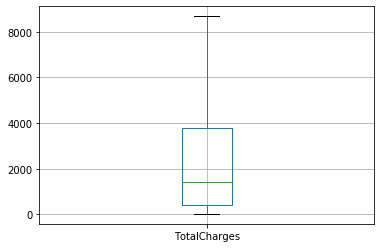

In [9]:
con.boxplot('TotalCharges')

Ок, без выбросов. Посмотрим на описание

In [10]:
con['TotalCharges'].describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

Ок... Медиана и среднее разнятся из за 8684, это должет быть выброс, но на диаграмме об этом не сказано... посмотрим на пропуски

In [11]:
con.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

Удалим пропуски

In [12]:
con = con.dropna().reset_index(drop = True)

In [13]:
con

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


Посмотрим, сколько раз встречаются id

In [14]:
con['customerID'].value_counts().sort_values(ascending = True)

2990-IAJSV    1
7639-LIAYI    1
8399-YNDCH    1
3967-KXAPS    1
0234-TEVTT    1
             ..
4803-LBYPN    1
3898-GUYTS    1
3620-EHIMZ    1
3724-BSCVH    1
5663-QBGIS    1
Name: customerID, Length: 7032, dtype: int64

Видим, что все id встречаются по одному разу, переходим к интернету

In [15]:
inet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Посмотрим на сведения

In [16]:
inet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


Больше изучать тут нечего, посмотрим на телефонную связь

In [17]:
ph.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [18]:
ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


Смотрим на информацию о персоне

In [19]:
per.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [20]:
per.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Посмотрим можено ли перевести в boolean SeniorCitizen

In [21]:
per.SeniorCitizen.value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

Можно, переводим

In [22]:
per['SeniorCitizen'] = per['SeniorCitizen'].astype('bool')

Думаю, элементарный EDA можно считатть сделанным) Исследовательский анализ будет потом, на следующем шаге.

# обработка дф и добавление фичей

Посмотрим на размеры выборок

In [23]:
print(per.shape)
print(con.shape)
print(ph.shape)
print(inet.shape)

(7043, 5)
(7032, 8)
(6361, 2)
(5517, 8)


Соединим две таблицы с похожим количеством строк по ID.

In [24]:
data = per.merge(con, on = 'customerID', how = 'outer')

In [25]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,False,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,False,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,Male,False,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,False,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,False,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50
7039,2234-XADUH,Female,False,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90
7040,4801-JZAZL,Female,False,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Male,True,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60


То же самое сделаем с остальными таблицами

In [26]:
data = data.merge(ph, how = 'outer', on = 'customerID')

In [27]:
data = data.merge(inet, how = 'outer', on = 'customerID')

In [28]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,False,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,False,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,False,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,False,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,False,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,False,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,Female,False,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,NaN,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,Male,True,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Fiber optic,No,No,No,No,No,No


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null bool
Partner             7043 non-null object
Dependents          7043 non-null object
BeginDate           7032 non-null object
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
MultipleLines       6361 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: bool(1), float64(2), object(17)
memory usage: 1.1+ MB


У нас есть пропуск в датах начала и конца, это принципиально важные данные, восстановить их не получится, удалим пустые значения, их не так уж и много. Несложно математически доказать, что где пропущена дата начала, там пропущена и дата конца, суда по информации о дф. Возьмем только те значения, которые вещественны

In [30]:
data = data[data['BeginDate'].isna() != True]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null bool
Partner             7032 non-null object
Dependents          7032 non-null object
BeginDate           7032 non-null object
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
MultipleLines       6352 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5512 non-null object
dtypes: bool(1), float64(2), object(17)
memory usage: 1.1+ MB


Остальные все пропуски заполним No, это будет отдельная категория

In [32]:
data[data.columns] = data[data.columns].fillna('No')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Пропусков остаться не должно

In [33]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [34]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,False,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,False,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,False,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,False,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,False,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,False,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,Female,False,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,Male,True,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Fiber optic,No,No,No,No,No,No


Переведем столбец даты начала пользования в дату

In [35]:
data['BeginDate'] = pd.to_datetime(data['BeginDate'], format = "%Y-%m-%d")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Промаркируем тех, кто хочет уйти и кто не уйдет в отдельном столбце. Если было no, то человек еще жив, если стоит дата, то уже ушел. 1 - ушел, 0 - еще жив

In [36]:
data.loc[data['EndDate'] == 'No', 'target'] = 0
data.loc[data['EndDate'] != 'No', 'target'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Там, где в столбце не написана дата, пусть там будет дата 1 февраля 2020, раз уж анализ делаем от того дня

In [37]:
data.loc[data['EndDate'] == 'No', 'EndDate'] = pd.datetime(2020, 2, 1, hour=0, minute=0, second=0)

In [38]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target
0,7590-VHVEG,Female,False,Yes,No,2020-01-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,...,29.85,No,DSL,No,Yes,No,No,No,No,0.0
1,5575-GNVDE,Male,False,No,No,2017-04-01,2020-02-01 00:00:00,One year,No,Mailed check,...,1889.50,No,DSL,Yes,No,Yes,No,No,No,0.0
2,3668-QPYBK,Male,False,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,...,108.15,No,DSL,Yes,Yes,No,No,No,No,1.0
3,7795-CFOCW,Male,False,No,No,2016-05-01,2020-02-01 00:00:00,One year,No,Bank transfer (automatic),...,1840.75,No,DSL,Yes,No,Yes,Yes,No,No,0.0
4,9237-HQITU,Female,False,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,...,151.65,No,Fiber optic,No,No,No,No,No,No,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,False,Yes,Yes,2018-02-01,2020-02-01 00:00:00,One year,Yes,Mailed check,...,1990.50,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0.0
7039,2234-XADUH,Female,False,Yes,Yes,2014-02-01,2020-02-01 00:00:00,One year,Yes,Credit card (automatic),...,7362.90,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0.0
7040,4801-JZAZL,Female,False,Yes,Yes,2019-03-01,2020-02-01 00:00:00,Month-to-month,Yes,Electronic check,...,346.45,No,DSL,Yes,No,No,No,No,No,0.0
7041,8361-LTMKD,Male,True,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,...,306.60,Yes,Fiber optic,No,No,No,No,No,No,1.0


Переведем столбец даты конца в дату

In [39]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format = "%Y-%m-%d %H:%M:%S")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Выберем из нее только дату, время откинем

In [40]:
data['EndDate'] = pd.to_datetime(data['EndDate']).dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Переведем столбец в дату

In [41]:
data['EndDate'] = pd.to_datetime(data['EndDate'], format = '%Y-%m-%d')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Найдем время жизни клиента, вычтем из второй даты первую и уберем слово days

In [42]:
data['divdate'] = (data['EndDate'] - data['BeginDate']).dt.days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,divdate
0,7590-VHVEG,Female,False,Yes,No,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,...,No,DSL,No,Yes,No,No,No,No,0.0,31
1,5575-GNVDE,Male,False,No,No,2017-04-01,2020-02-01,One year,No,Mailed check,...,No,DSL,Yes,No,Yes,No,No,No,0.0,1036
2,3668-QPYBK,Male,False,No,No,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,...,No,DSL,Yes,Yes,No,No,No,No,1.0,61
3,7795-CFOCW,Male,False,No,No,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),...,No,DSL,Yes,No,Yes,Yes,No,No,0.0,1371
4,9237-HQITU,Female,False,No,No,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,...,No,Fiber optic,No,No,No,No,No,No,1.0,61


Уберем уже не нужные нам признаки даты начала и даты конца

In [44]:
data = data.drop(['BeginDate', 'EndDate'], axis = 1)

In [45]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,divdate
0,7590-VHVEG,Female,False,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,DSL,No,Yes,No,No,No,No,0.0,31
1,5575-GNVDE,Male,False,No,No,One year,No,Mailed check,56.95,1889.50,No,DSL,Yes,No,Yes,No,No,No,0.0,1036
2,3668-QPYBK,Male,False,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,No,DSL,Yes,Yes,No,No,No,No,1.0,61
3,7795-CFOCW,Male,False,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,DSL,Yes,No,Yes,Yes,No,No,0.0,1371
4,9237-HQITU,Female,False,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,No,Fiber optic,No,No,No,No,No,No,1.0,61


Переведем признаки в более удобные виды

In [46]:
data['target'] = data['target'].astype('bool')
data.loc[data['SeniorCitizen'] == 'False', 'SeniorCitizen'] = 0
data.loc[data['SeniorCitizen'] == 'True', 'SeniorCitizen'] = 1

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [47]:
data['MonthlyCharges'] = round(data['MonthlyCharges']).astype('int64')
data['TotalCharges'] = round(data['MonthlyCharges']).astype('int64')

In [48]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,target,divdate
0,7590-VHVEG,Female,False,Yes,No,Month-to-month,Yes,Electronic check,30,30,No,DSL,No,Yes,No,No,No,No,False,31
1,5575-GNVDE,Male,False,No,No,One year,No,Mailed check,57,57,No,DSL,Yes,No,Yes,No,No,No,False,1036
2,3668-QPYBK,Male,False,No,No,Month-to-month,Yes,Mailed check,54,54,No,DSL,Yes,Yes,No,No,No,No,True,61
3,7795-CFOCW,Male,False,No,No,One year,No,Bank transfer (automatic),42,42,No,DSL,Yes,No,Yes,Yes,No,No,False,1371
4,9237-HQITU,Female,False,No,No,Month-to-month,Yes,Electronic check,71,71,No,Fiber optic,No,No,No,No,No,No,True,61


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null bool
Partner             7032 non-null object
Dependents          7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null int64
TotalCharges        7032 non-null int64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
target              7032 non-null bool
divdate             7032 non-null int64
dtypes: bool(2), int64(3), object(15)
memory usage: 1.0+ MB


Посмотрим на распределения количественных величин

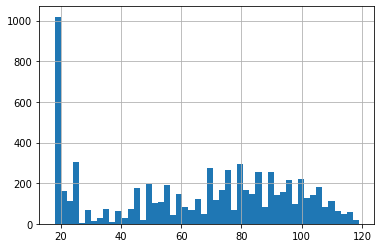

In [50]:
data['TotalCharges'].hist(bins = 50)

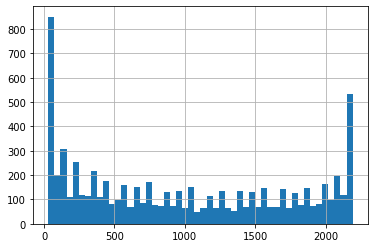

In [51]:
data['divdate'].hist(bins = 50)

In [52]:
data.groupby('target')['divdate'].mean()

target
False    1146.885532
True      547.352060
Name: divdate, dtype: float64

В среднем, люди склонные к оттоку держатся меньше, чем те, кто не склонны к оттоку

Вывод: Признаки обработаны и готовы к использовнаию для построения моделей

# Кодирование признаков и построение моделей

Посмотрим на корреляцию количественных признаков

In [55]:
features = data.drop(['customerID', 'target'], axis = 1)
cor_check = features[['MonthlyCharges', 'TotalCharges', 'divdate']]
cor_check.corr()

,MonthlyCharges,TotalCharges,divdate
MonthlyCharges,1.00000,1.00000,0.24667
TotalCharges,1.00000,1.00000,0.24667
divdate,0.24667,0.24667,1.00000


Видим сильную корелляцию между признаками месячных затрат и полных, если уберем один из них, то ничего не потеряем, осущетвим это

Разделим дф на признаки и целевой признак

In [57]:
features = data.drop(['customerID', 'target', 'MonthlyCharges'], axis = 1)
target = data['target']

Закодируем качественные переменные

In [58]:
features = pd.get_dummies(features, drop_first = True)

In [59]:
features

,SeniorCitizen,TotalCharges,divdate,gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,False,30,31,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,False,57,1036,1,0,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
2,False,54,61,1,0,0,0,0,1,0,...,1,0,0,0,1,1,0,0,0,0
3,False,42,1371,1,0,0,1,0,0,0,...,0,0,0,0,1,0,1,1,0,0
4,False,71,61,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,85,730,1,1,1,1,0,1,0,...,1,1,0,0,1,0,1,1,1,1
7039,False,103,2191,0,1,1,1,0,1,1,...,0,1,1,0,0,1,1,0,1,1
7040,False,30,337,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
7041,True,74,123,1,1,0,0,0,1,0,...,1,1,1,0,0,0,0,0,0,0


Стандартизируем признаки

In [60]:
scaler = StandardScaler()
scaler.fit(features)
features[features.columns] = scaler.transform(features[features.columns])

In [61]:
features

,SeniorCitizen,TotalCharges,divdate,gender_Male,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),...,PaymentMethod_Mailed check,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
0,-0.440327,-1.156545,-1.280334,-1.009430,1.035617,-0.652305,-0.514537,-0.561364,0.828939,-0.525351,...,-0.543604,-0.854336,-0.886896,-0.52513,-0.633746,1.378330,-0.723918,-0.639260,-0.790186,-0.796849
1,-0.440327,-0.259102,0.064866,0.990658,-0.965608,-0.652305,1.943495,-0.561364,-1.206361,-0.525351,...,1.839576,-0.854336,-0.886896,-0.52513,1.577918,-0.725516,1.381372,-0.639260,-0.790186,-0.796849
2,-0.440327,-0.358818,-1.240179,0.990658,-0.965608,-0.652305,-0.514537,-0.561364,0.828939,-0.525351,...,1.839576,-0.854336,-0.886896,-0.52513,1.577918,1.378330,-0.723918,-0.639260,-0.790186,-0.796849
3,-0.440327,-0.757681,0.513266,0.990658,-0.965608,-0.652305,1.943495,-0.561364,-1.206361,-0.525351,...,-0.543604,-0.854336,-0.886896,-0.52513,1.577918,-0.725516,1.381372,1.564308,-0.790186,-0.796849
4,-0.440327,0.206238,-1.240179,-1.009430,-0.965608,-0.652305,-0.514537,-0.561364,0.828939,-0.525351,...,-0.543604,-0.854336,1.127527,-0.52513,-0.633746,-0.725516,-0.723918,-0.639260,-0.790186,-0.796849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,-0.440327,0.671579,-0.344717,0.990658,1.035617,1.533025,1.943495,-0.561364,0.828939,-0.525351,...,1.839576,1.170500,-0.886896,-0.52513,1.577918,-0.725516,1.381372,1.564308,1.265525,1.254943
7039,-0.440327,1.269874,1.610843,-1.009430,1.035617,1.533025,1.943495,-0.561364,0.828939,1.903490,...,-0.543604,1.170500,1.127527,-0.52513,-0.633746,1.378330,1.381372,-0.639260,1.265525,1.254943
7040,-0.440327,-1.156545,-0.870751,-1.009430,1.035617,1.533025,-0.514537,-0.561364,0.828939,-0.525351,...,-0.543604,-0.854336,-0.886896,-0.52513,1.577918,-0.725516,-0.723918,-0.639260,-0.790186,-0.796849
7041,2.271039,0.305954,-1.157192,0.990658,1.035617,-0.652305,-0.514537,-0.561364,0.828939,-0.525351,...,1.839576,1.170500,1.127527,-0.52513,-0.633746,-0.725516,-0.723918,-0.639260,-0.790186,-0.796849


Разбиваем на тренировочную и тестовую выборки

In [62]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state = 123, test_size = 0.3)

Напишем цикл, подбирающий нашей модели подходящие гиперпараметры

In [63]:
model_rf = None
trees = 0
depth = 0
acc = 0
roc = 0
for n in range(1, 20):
    for i in range(1,20):
        model = RandomForestClassifier(random_state = 12345, n_estimators = n, max_depth = i)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]    
        if (roc < roc_auc_score(target_valid, probabilities_one_valid)):
            depth = i
            trees = n
model_rf = RandomForestClassifier(random_state = 123, max_depth = depth, n_estimators = trees)
model_rf.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:,1]
print('accuracy для модели = ', accuracy_score(target_valid, model_rf.predict(features_valid)))
print('roc_auc = ', roc_auc_score(target_valid, probabilities_one_valid))

accuracy для модели =  0.7890995260663507
roc_auc =  0.8331343704520207


In [64]:
depth_1 = 0
n1 = 0
roc = 0
model_xb = None
for depth in range(1, 20):
    for n in range(1,10):
        xb = xgboost.XGBClassifier(n_estimators = n, max_depth = depth, random_state = 123, iterations = 150, learning_rate = 0.0001)
        xb.fit(features, target)
        probabilities_valid = xb.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:,1]
        if roc < roc_auc_score(target_valid, probabilities_one_valid):
            roc = roc_auc_score(target_valid, probabilities_one_valid)
            n1 = n
            model_xb = xb
            depth_1 = depth
print('roc_auc = ', roc)
print('accuracy ', accuracy_score(target_valid, model_xb.predict(features_valid)))

roc_auc =  0.9394316802011661
accuracy  0.9023696682464455


roc_auc =  0.9394316802011661
accuracy = 0.9023696682464455

вывод: Были обучены 2 модели, каждая из которых показала достойный результат. Считаю, что задачу можно считать выполненной и использовать модель с градиентным бустингом.

<font color='blue'>Вопрос 1. "При моделировании существует проблематика мультиколлинеарности.(когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8).Есть ли она у нас?  Если есть - надо  решать по понятиям:) (удалить лишнее)". Ну что ж, решим вопроc через корреляционную таблицу

In [ ]:
features = data.drop(['customerID', 'target'], axis = 1)
features

In [ ]:
cor_check = features[['MonthlyCharges', 'TotalCharges', 'divdate']]
cor_check

In [ ]:
cor_check.corr()

<font color='blue'>Видим, что у нас коррелируют полные и месячные затраты, что вполне логично. Удалив этот признак, мы ничего не потеряем, так как для алгоритма это фактически один и тот же признак, мы ничего не потеряем убрав его) Сделал это в самой работе

<font color='blue'>Вопрос 2. "Будет здорово, если построишь график важности факторов". Вообще, я уже делал этот анализ, но здесь не писал его. Там самый большой вес 0.3, и стоит он на времени жизни клиента, что было в каком то смысле очевидно. Посмотрим еще раз

In [ ]:
model_xb.feature_importances_ 

Ого, в этот раз самый большой вес аж 0.6... посмотрим что это за признак

In [ ]:
features.columns[13]

хммм... интересный признак

In [ ]:
pd.Series(model_xb.feature_importances_).hist(bins = 10)

из распределения можно видеть, что очень много весов близких к нулю, но это не значит, что они не важны, хотя видно, что гендер практически вообще не влияет на результат, как и не влияет тип телефонной связи. У нас есть хороший результат, думаю, оставлять только более менее вещественные веса не очень нужно , так как мы достигли своей цели)